In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# PART 1

### Import data

In [35]:
X_train = pd.read_csv("data/data_labeled/X_train.csv")
y_train = pd.read_csv("data/data_labeled/y_train.csv",header=None)


X_test = pd.read_csv("data/data_labeled/X_test.csv")
y_test = pd.read_csv("data/data_labeled/y_test.csv",header=None)

### Categorical data processing

In [36]:

#tranform to 0-4 because labels have a sense of order
consumption_map = {"Very low":0, "Low":1, "Moderate":2, "High":3, "Very high":4}
X_train["sarsaparilla"] = X_train["sarsaparilla"].replace(consumption_map);
X_train["smurfberry liquor"] = X_train["smurfberry liquor"].replace(consumption_map);
X_train["smurfin donuts"] = X_train["smurfin donuts"].replace(consumption_map);
X_test["sarsaparilla"] = X_test["sarsaparilla"].replace(consumption_map);
X_test["smurfberry liquor"] = X_test["smurfberry liquor"].replace(consumption_map);
X_test["smurfin donuts"] = X_test["smurfin donuts"].replace(consumption_map);


#tranform professions into one-hot encoding because they don't have a sense of order
def one_hot_encode(data,column="profession"):
    categories = np.unique(data[column])
    for i in range(len(categories)): #pour chaque profession
        new_col = []
        for entry in data[column]: #pour chaque patient
            if entry == categories[i]:
                new_col.append(1) #Si la profession == profession du patient
            else:
                new_col.append(0) #Si non
        data.insert(len(data.columns),categories[i],new_col)
    data.drop(column,axis=1,inplace=True)
        
try:
	one_hot_encode(X_train)
	one_hot_encode(X_test)
except:
	print("Already processed")
     
#Drop pictures
X_train.drop("img_filename",axis=1,inplace=True)
X_test.drop("img_filename",axis=1,inplace=True)

## Normalization

In [37]:
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
X_train = pd.DataFrame(standardizer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(standardizer.fit_transform(X_test),columns=X_train.columns)

## Visualise tranformed dataset

(array([-1.12307588, -0.32202318,  0.47902951,  1.28008221,  2.08113491]), array([272, 351, 170, 117,  90]))
(array([-1.97407681, -1.08685128, -0.19962574,  0.68759979,  1.57482532]), array([ 80, 164, 351, 261, 144]))
(array([-1.47513321, -0.75273693, -0.03034064,  0.69205564,  1.41445192]), array([187, 185, 219, 217, 192]))


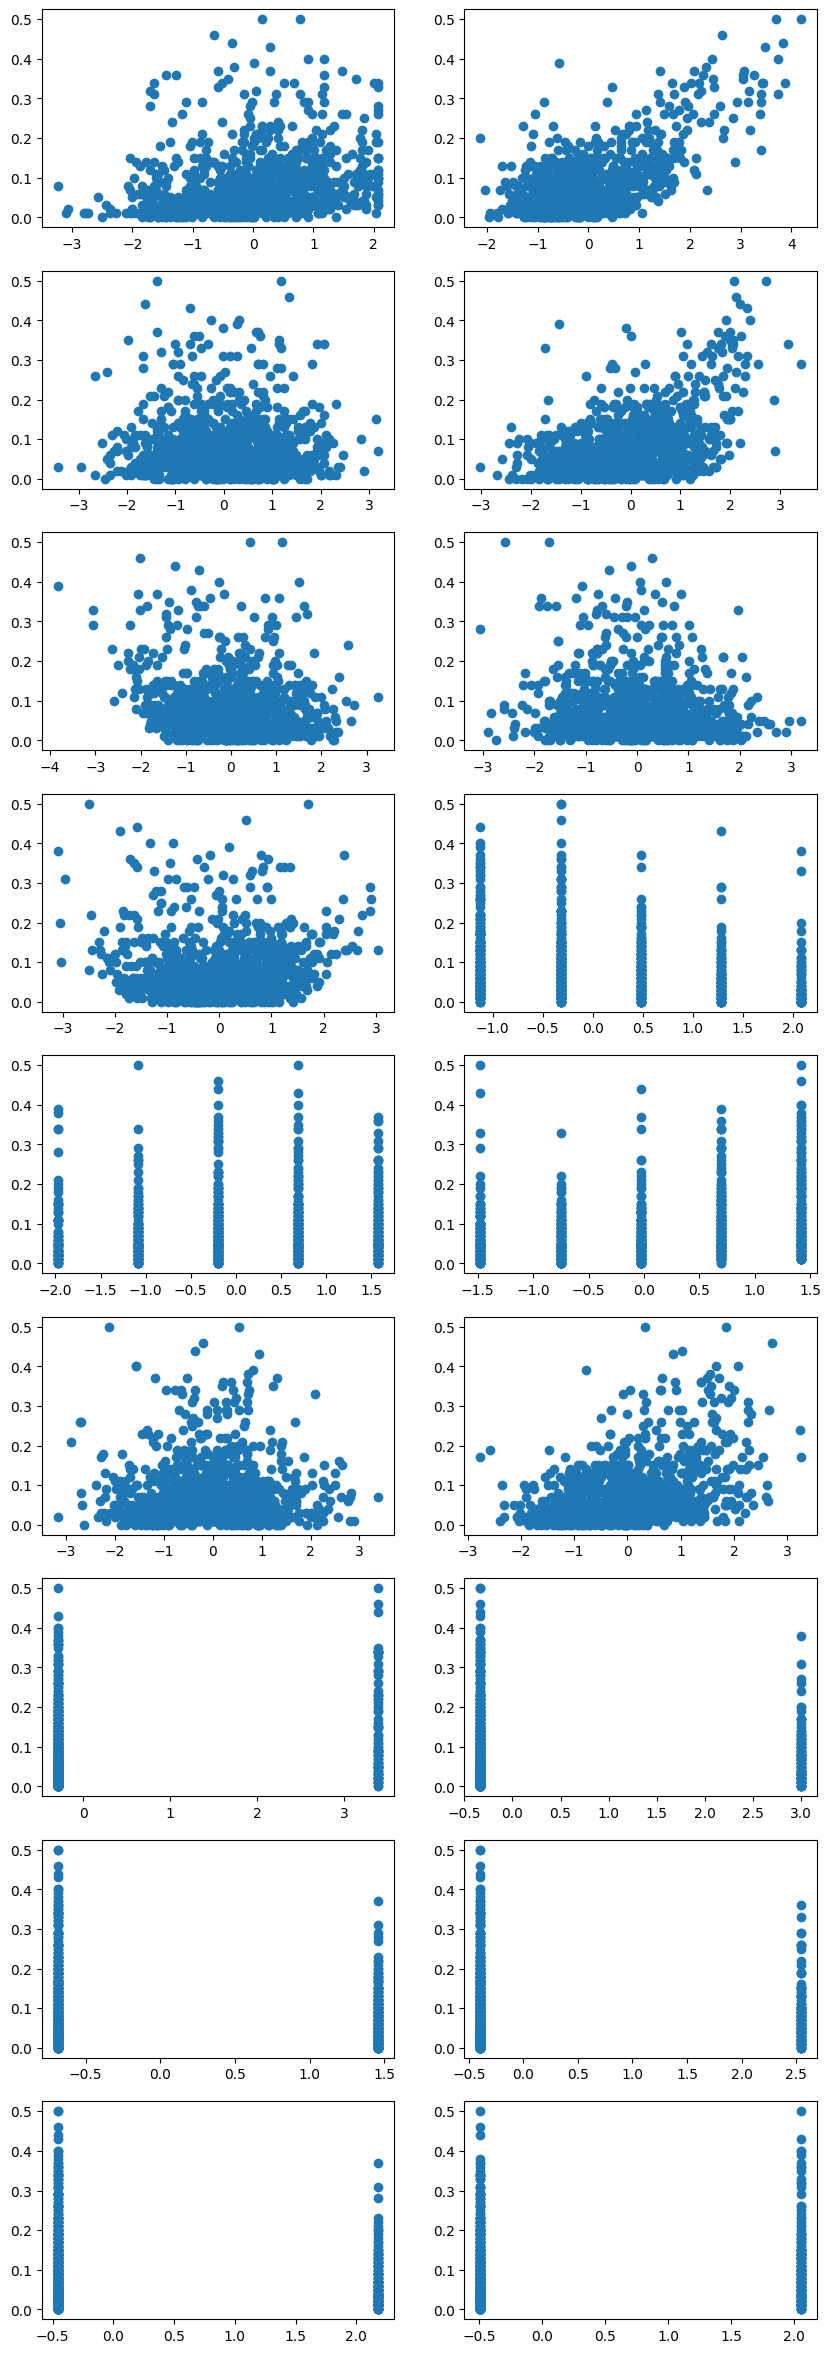

In [38]:
fig, axs = plt.subplots(9, 2, figsize=(10,30))

for index in range(18):
    axs[index//2,index%2].scatter(X_train[X_train.columns[index]],y_train)

		
print(np.unique(X_train["sarsaparilla"],return_counts=True))
print(np.unique(X_train["smurfberry liquor"],return_counts=True))
print(np.unique(X_train["smurfin donuts"],return_counts=True))

## Import X_unlabeled

In [39]:
#Import unlabeled data
X_unlabeled = pd.read_csv("data/data_unlabeled/X.csv")

#process categorical
X_unlabeled["sarsaparilla"] = X_unlabeled["sarsaparilla"].replace(consumption_map);
X_unlabeled["smurfberry liquor"] = X_unlabeled["smurfberry liquor"].replace(consumption_map);
X_unlabeled["smurfin donuts"] = X_unlabeled["smurfin donuts"].replace(consumption_map);

try:
	one_hot_encode(X_unlabeled)
except:
	print("Already processed")
     
#Drop pictures
X_unlabeled.drop("img_filename",axis=1,inplace=True)

#Normalize
X_unlabeled = pd.DataFrame(standardizer.transform(X_unlabeled),columns=X_train.columns)


## Greedy search

In [40]:
#To evaluate teh greedy search
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features):
    
    # train model
    model.fit(X_train[selected_features].values, y_train.values.ravel())
    
    # evaluate model
    y_pred = model.predict(X_test[selected_features].values) 
    rmse = np.sqrt(np.mean((y_pred-y_test.values.ravel() )**2))
    
    print(f"selected features: ")
    for i,feature in enumerate(selected_features):
        print(f"- {feature}")
    print("----------------------------------")
    print(f"RMSE basic MLP: {rmse:5.6f}")

In [41]:

model = LinearRegression() 
kf = KFold(n_splits=5, shuffle=True, random_state=42) #replaces the need to have a dedicated validation set
sfs = SequentialFeatureSelector(model,direction='backward', cv=kf, n_jobs=-1)
sfs.fit(X_train,y_train)
selected_features = sfs.get_feature_names_out() # to modify

In [42]:
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- food production
----------------------------------
RMSE basic MLP: 0.055596


## Output baseline predictions

In [43]:
# train model
model.fit(X_train[selected_features].values, y_train.values.ravel())
# make predictions on unlabeled data
y_pred = model.predict(X_unlabeled[selected_features].values)
pd.DataFrame(y_pred, columns=['y_pred']).to_csv("predictions/y_pred_baseline.csv",header=False, index=False)

## Without Greedy Search

In [44]:
model = LinearRegression()
selected_features = X_train.columns
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------
RMSE basic MLP: 0.056053


# Part 2

## Mutual Information Feature Selection

In [45]:
import plotly.express as px
from sklearn.feature_selection import mutual_info_regression

mutual_info = pd.Series(mutual_info_regression(X_train,y_train))
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)


blood pressure                   0.250581
cholesterol                      0.101285
weight                           0.090474
smurfin donuts                   0.066993
potassium                        0.055928
sarsaparilla                     0.051352
vitamin D                        0.049836
age                              0.035631
craftsmanship                    0.022342
hemoglobin                       0.014234
height                           0.008626
food production                  0.005791
smurfberry liquor                0.000000
calcium                          0.000000
administration and governance    0.000000
manufacturing                    0.000000
resource extraction              0.000000
services                         0.000000
dtype: float64

In [46]:
mi_matrix = []

for i in X_train.columns:
    row = []
    for j in X_train.columns:
        if j == i:
            row.append(0)
        else:row.append(float(mutual_info_regression(X_train[[i]],X_train[j])[0]))
    mi_matrix.append(row)

fig = px.imshow(
    mi_matrix,
    text_auto=True,
    color_continuous_scale=px.colors.sequential.Burg,
    x=X_train.columns,
    y=X_train.columns,
)
fig.update_xaxes(side="top")
fig.update_layout(
    height=800,  # Adjust these values as needed
    width=900
)

fig.show()

## Polynomial Regression

In [47]:
model = LinearRegression()

#In reality, I did until 4 but that took a long time
for degree in [1, 2]:
    print(f"=== Polynomial Degree {degree} ===")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
    X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))

    # Perform backward feature selection
    sfs = SequentialFeatureSelector(model, direction='forward',n_features_to_select=15,n_jobs=-1,cv=kf)
    sfs.fit(X_train_poly, y_train)

    selected_features = sfs.get_feature_names_out()
    
    # Evaluate
    evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, selected_features)

=== Polynomial Degree 1 ===
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- vitamin D
- weight
- administration and governance
- craftsmanship
- manufacturing
- services
----------------------------------
RMSE basic MLP: 0.056014
=== Polynomial Degree 2 ===
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- blood pressure^2
- cholesterol height
- cholesterol weight
- hemoglobin^2
- height weight
- potassium^2
- weight^2
----------------------------------
RMSE basic MLP: 0.041886


### Output polynomial

In [48]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
X_unlabeled_poly = pd.DataFrame(poly.transform(X_unlabeled), columns=poly.get_feature_names_out(X_train.columns))

# Perform forward feature selection
sfs = SequentialFeatureSelector(model, direction='forward',n_features_to_select=10,n_jobs=-1,cv=kf)
sfs.fit(X_train_poly, y_train)
selected_features = sfs.get_feature_names_out()

# train model
model.fit(X_train_poly[selected_features].values, y_train.values.ravel())
# make predictions on unlabeled data
y_pred = model.predict(X_unlabeled_poly[selected_features].values)

In [49]:
# Save to CSV
pd.DataFrame(y_pred, columns=['y_pred']).to_csv("predictions/y_pred_polynomial.csv",header=False, index=False)


### 2nd degree without greedy search

In [50]:
model = LinearRegression()

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))

selected_features = X_train_poly.columns
evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, selected_features)

selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
- age^2
- age blood pressure
- age calcium
- age cholesterol
- age hemoglobin
- age height
- age potassium
- age sarsaparilla
- age smurfberry liquor
- age smurfin donuts
- age vitamin D
- age weight
- age administration and governance
- age craftsmanship
- age food production
- age manufacturing
- age resource extraction
- age services
- blood pressure^2
- blood pressure calcium
- blood pressure cholesterol
- blood pressure hemoglobin
- blood pressure height
- blood pressure potassium
- blood pressure sarsaparilla
- blood pressure smurfberry liquor
- blood pressure smurfin donuts
- blood pressure vitamin D
- blood pressure weight
- blood pressure administration and governance
- blood pressure craftsma